# <img style="float: left; padding-right: 10px; width: 45px" src="twitter.png"> Machine Learning & Analysis for Twitter Bot Detection

## Project Report


**Group 23**<br/>
**Karthikeya Bolla, Zareh Vasquez**

<hr style="height:2pt">



In [2]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

# Introduction

**Twitter** is an online social networking service that allows users to post 140 character messages known as **_tweets_**. It is one of the top ten visited websites in the world with a total of 319 million monthly active users [1]. To interact and access this high magnitude of content, Twitter provides REST and Streaming APIs that enables free access to several endpoints [2]. One of the advantages of using Twitter API is, users can control their Twitter accounts with automated software programs called **Twitter Bots**. These bots are software programs that autonomously tweet, retweet, like and perform other tweet related actions. Software Developers developing these bots should adhere to automation rules [3] set by Twitter. <br><br>
With the advent of automation and need to constantly share information, bots became a necessity to reduce human intervention and effort. In the era of information, understanding the behavior of bots has been an area of interest to academics because of the positive and negative influence cast by bot activity. One of the most recent examples of bot abuse is the Russian interference in U.S. 2016 presidential elections. Spreading fake news using Twitter bots has changed the outcome of elections [4]. Considering these facts, it is necessary to identify bots in Twitter space and understand how bot activity differs from that of humans. The project emphasizes on detecting bots using Machine Learning techniques

### Importing necessary libraries 

In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json
import nltk
import string
import os
import re
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
%matplotlib inline

# Data! Data! Data!

### Dataset
Dataset was mined from Twitter using Twitter's Search API and **_tweepy_**, Python library for accessing Twitter API. Data mined is stored as **JSON (JavaScript Object Notation)** file. Note that details concerning mining Twitter for data are not presented here as it is out of scope.  


In [5]:
# read JSON file
filepath = os.getcwd()
df = pd.read_json(filepath + '/data/real_tweets.json', orient = 'columns')

#### Describing the data

In [12]:
print('Dataset Shape: ', df.shape, '\n')
print('Columns in dataset: ', df.columns)

Dataset Shape:  (42723, 64) 

Columns in dataset:  Index(['bot', 'contributors', 'coordinates', 'created_at', 'favorite_count',
       'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'retweet_count',
       'retweeted', 'retweeted_status', 'source', 'text', 'truncated',
       'user_contributors_enabled', 'user_created_at', 'user_default_profile',
       'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_follow_request_sent',
       'user_followers_count', 'user_following', 'user_friends_count',
       'user_geo_enabled', 'user_has_extended_profile', 'user_id',
       'user_id_str', 'user_is_translation_enabled', 'user_is_translator',
       'user_lang', 'user_listed_count', 'user_locatio

Every record in the dataset is composed of 63 attributes. We have added one extra attribute titled **'bot'** which isolates human accounts' tweets from bot accounts' tweets. The attribute takes a value **1** for tweets arising from bot accounts and value **0** for tweets belonging to human accounts. Therefore, attribute **'bot'** can be seen as **_binary_** class variable. <br>

Detailed analysis of tweet data showed that the tweet related attributes carry information about **tweet** and the twitter account attributes carry information about the account, be it user or bot. Therefore these 63 attributes can be seperated into two classes; attributes describing twitter account properties and attributes describing tweet properties. Among the 63 attributes, the ones mentioned in below code are of particular interest. Note that the attributes of interest are seperated into two categories; attributes describing tweets and attributes describing accounts (again, accounts here are both bot and human accounts). <br>

In [21]:
# create a final processed dataframe using columns of interest    
# isolate columns that are of interest concerning 'tweet' made
tweet_cols_interest = ['bot',
                       'created_at',
                       'favorite_count',
                       'favorited',
                       'retweet_count',
                       'retweeted',
                       'source',
                       'text']

# isolate columns that are of interest concerning 'user'
user_cols_interest = ['bot',
                      'user_favourites_count',
                      'user_followers_count',
                      'user_friends_count',
                      'user_id_str',
                      'user_listed_count',
                      'user_screen_name',
                      'user_statuses_count',
                      'user_verified']

We have created two dataframes based off of account attributes and tweet attributes. These will be analyzed seperately.
1. Account attributes will be used to perform Bot vs. Human Classification, and
2. Tweet attributes will be used to perform Topic Modelling using Natural Language Processing

In [22]:
# tweet attributes' dataframe
df_tweet = df[tweet_cols_interest].copy(deep = True)

# user account attributes' dataframe
df_user = df[user_cols_interest].copy(deep = True)

### Data Processing

During data gathering process, we gathered $(approx.)$ 100 tweets associated with 164 bot accounts and 705 human accounts. A total of 42723 tweets were gathered. Note that not all accounts had 100 tweets.

As mentioned above, we will be using account related attributes (highlighted below) to perform bot vs. human classification. Dataset using the following (account related) attributes is shown below
1. 'bot',
2. 'user_favourites_count',
3. 'user_followers_count',
4. 'user_friends_count',
5. 'user_id_str',
6. 'user_listed_count',
7. 'user_screen_name',
8. 'user_statuses_count',
9. 'user_verified' 

In [19]:
print(df_user.head())
print()

,bot,user_favourites_count,user_followers_count,user_friends_count,user_id_str,user_listed_count,user_screen_name,user_statuses_count,user_verified
0,1,11024,553243,334,105719173,126,iconnnz,200224,False
1,1,11024,553243,334,105719173,126,iconnnz,200224,False
2,1,11024,553243,334,105719173,126,iconnnz,200224,False
3,1,11024,553243,334,105719173,126,iconnnz,200224,False
4,1,11024,553243,334,105719173,126,iconnnz,200224,False


There are redundancies $(approx.)$ every 100 records. It is so because, these attributes correspond to accounts and every record represents individual tweet and 100 tweets are gathered for every account. Thus for a count of 100 recursively, tweet attributes are different but account attributes are repeating as tweets belong tothe same account. <br><br>
Upon removing redundancies, the dataset looks as

In [25]:
# account related dataframe (a.k.a) user related dataframe is now composed of duplicates.
# removing duplicates
df_user = df_user.drop_duplicates()
print(df_user.shape)

(869, 9)


After removing redundant attributes we are left with a total of 869 unique records indicating that the dataset is gathered by searching 100 tweets for every user along these 869 account users.

Class attribute **bot** which previously contained binary labels **1**s and **0**s is now converted to $String$ datatype using _**yes**_ and _**no**_.

In [27]:
# modifying values in 'bot' column to 'yes' and 'no'
df_user.loc[df_user.bot == 1, 'bot'] = 'yes'
df_user.loc[df_user.bot == 0, 'bot'] = 'no'

As there are 164 records corresponding to bots and 705 corresponsding to humans, we need to sample he data equally so as to prevent _**Class-Imbalance Problem**_.

In [31]:
# distribution of bots and humans
nBots = df_user[df_user['bot'] == 'yes'].shape[0]
nHumans = df_user[df_user['bot'] == 'no'].shape[0]

print('Number of Bot accounts gathered: ', nBots)
print('Number of Human accounts gathered: ', nHumans)

Number of Bot accounts gathered:  164
Number of Human accounts gathered:  705


In [37]:
# Due to class-imbalance problem i.e. nBots < nHumans, 
# data is sampled equally for number of bots and humans
df_user_bots = df_user[df_user['bot'] == 'yes'].reset_index(drop = True)
df_user_humans = df_user[df_user['bot'] == 'no'].reset_index(drop = True)

# shuffle the data and sample first 164 records; the size of df_user_bots
df_user_humans = df_user_humans.sample(frac = 1, random_state = 12345).reset_index(drop = True)
df_user_humans = df_user_humans.iloc[np.arange(df_user_bots.shape[0])]

print('Number of Bot accounts sampled: ', df_user_bots.shape[0])
print('Number of Human accounts sampled: ', df_user_humans.shape[0])

Number of Bot accounts sampled:  164
Number of Human accounts sampled:  164


Create a master dataset combining records concerning bots and humans

In [34]:
# combining bots and humans dataset to create master dataset
df_master = pd.concat([df_user_bots, df_user_humans])
df_master = df_master.sample(frac = 1, random_state = 12345).reset_index(drop = True)

### Test-Train Split

Split the dataset using 80 - 20 rule.

In [36]:
# creating test-train split
nRows, nCols = df_master.shape
idx = np.arange(nRows)
np.random.seed(12345)
np.random.shuffle(idx) 
train_idx, test_idx = idx[ : int(0.8 * nRows)], idx[int(0.8 * nRows) : ]
train, test = df_master.iloc[train_idx].reset_index(drop = True), df_master.loc[test_idx].reset_index(drop = True)

# Selecting necessary columns for modelling
cols_not_needed = ['user_id_str', 'user_screen_name']
train_modified = train.drop(cols_not_needed, axis = 1)
test_modified = test.drop(cols_not_needed, axis = 1)
 
# convert 'user_verified' from 'bool' to 'binary (int64)' valued attribute
train_modified['user_verified'] = train_modified['user_verified'].astype(int)
test_modified['user_verified'] = test_modified['user_verified'].astype(int)

# Ready the dataset
X_train, y_train = train_modified.copy(deep = True), pd.DataFrame(train_modified['bot'], columns = ['bot'])
X_test, y_test = test_modified.copy(deep = True), pd.DataFrame(test_modified['bot'], columns = ['bot'])
del X_train['bot']
del X_test['bot']

### Scale the dataset - Standardization

In [40]:
# standardization
train_means = np.mean(X_train, axis = 0)
train_std = np.std(X_train, axis = 0)
X_train = (X_train - train_means) / train_std
X_test = (X_test - train_means) / train_std

print('Training Data:', X_train.shape)
print('Test Data:', X_test.shape)

Training Data: (262, 6)
Test Data: (66, 6)


# Principal Component Analysis

The dataset is not $2D$ or $3D$ and hence visualization is tough. Let's check if dimensionality reduction is possible so as to reduce the number of attributes for better visualization and model interpretation.

Variance explained by principal components: [0.33603229 0.22124037 0.15989878 0.15371146 0.10381693 0.02530017]


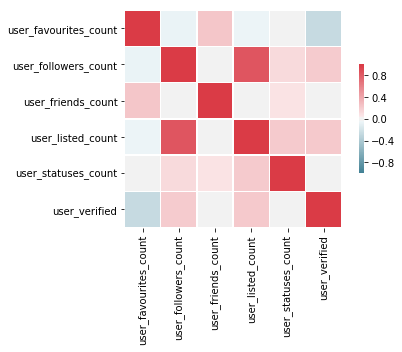

In [41]:
# Principal Component Analysis

# compute correlation matrix
corr_matrix = np.cov(X_train.T)

# upper-triangular matrix mask
mask = np.zeros_like(corr_matrix, dtype = np.bool)

# color mamp palette
cus_map = sns.diverging_palette(220, 10, as_cmap = True)

# drawing the heatmap
sns.heatmap(corr_matrix, 
            mask = mask, 
            cmap = cus_map, 
            vmax = 1.0, 
            center = 0,
            vmin = -1.0,
            square = True,
            xticklabels = list(X_train.columns),
            yticklabels = list(X_train.columns),
            linewidths = 0.5,
            cbar_kws = {'shrink' : 0.5})

# computing Principal Components
pca = PCA()
pca.fit(X_train)
X_train_new = pca.transform(X_train)
print('Variance explained by principal components:', pca.explained_variance_ratio_)

#### Analysis 
It can be seen that there isn't much correlation among variables and variance explained by individual principal components is not significatnt as the highest amount variance explained is only 33%. So using PCA will not necessarily simplify the visualization paradigm.

# Logistic Regression

Looking at the problem definition of identifying bots vs. humans, it can be seen that it is a binary classification problem. Therefore **Logistic Regression** classification model is used.

In [51]:
# seeting up the inverse of regularization parameter
C_arr = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

# Using CrossValidation to choose best 'C'
logreg = LogisticRegressionCV(Cs = C_arr, cv = 10, scoring = 'accuracy')
logreg.fit(X_train.values, y_train['bot'].values)
yes_class_scores = logreg.scores_['yes']
yes_class_scores, no_class_scores = np.mean(yes_class_scores, axis = 1), 1 - np.mean(yes_class_scores, axis = 1)

for c_val, score_val in zip(C_arr, yes_class_scores):
    print('C :', c_val, '\t\t', 'Score:', score_val)

best_C = C_arr[np.argmax(yes_class_scores)]
print('Best C value is ', best_C)

C : 1e-06 		 Score: 0.735042735042735
C : 1e-05 		 Score: 0.8603988603988605
C : 0.0001 		 Score: 0.8119658119658121
C : 0.001 		 Score: 0.7041420118343196
C : 0.01 		 Score: 0.8550295857988167
C : 0.1 		 Score: 0.7692307692307693
C : 1 		 Score: 0.7751479289940829
C : 10.0 		 Score: 0.7662721893491125
C : 100.0 		 Score: 0.7958579881656807
C : 1000.0 		 Score: 0.8184615384615385
Best C value is  1e-05


Train the model with best **$C$** and test the same on test set

In [44]:
# train the model with best C and predict on test set
logreg = LogisticRegression(C = best_C, random_state = 12345)
logreg.fit(X_train.values, y_train['bot'].values)
y_test_pred = logreg.predict(X_test.values)
acc = accuracy_score(y_test_pred, y_test['bot'].values)
print('Logistic Regression Accuracy Score: ', acc)

Logistic Regression Accuracy Score:  0.8787878787878788


#### Analysis
Logistic Regression model's test set accuracy is $87.87$%

# Random Forests

To fit Random Forests model, we need to 
1. Crossvalidate on depth of trees
2. Determine the number of trees to generate so as to form a forest

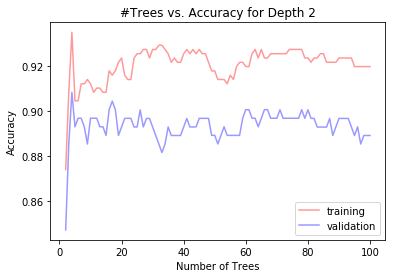

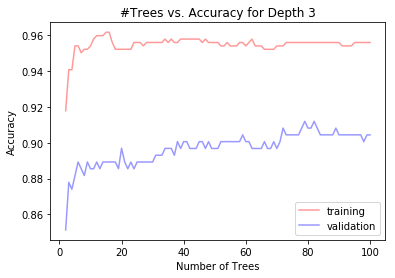

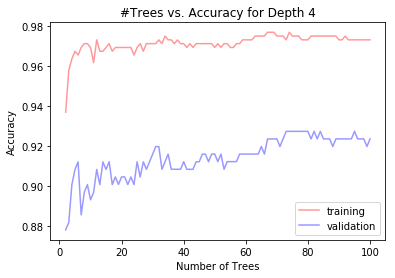

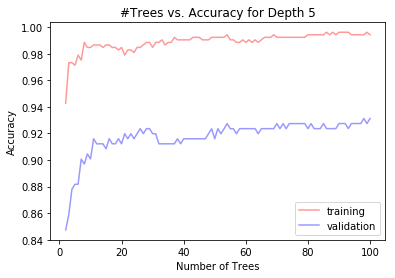

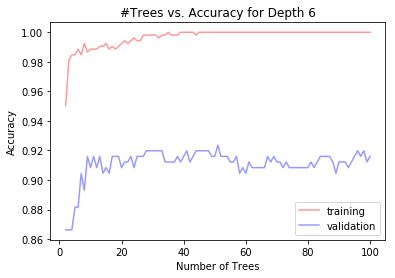

In [54]:
# depths (2, 3, 4, 6)
depths = np.arange(2, 7)

# no. of trees = 100
nTrees = np.arange(2, 101)

for depth in depths:    
    
    # instantiate RandomForestClassifier
    rf = RandomForestClassifier(max_depth = depth, random_state = 12345)
    
    # generate training, validation sets and their scores
    train_scores, valid_scores = validation_curve(rf, 
                                                  X_train.values, 
                                                  y_train['bot'].values, 
                                                  param_name = 'n_estimators', 
                                                  param_range = nTrees, 
                                                  scoring = 'accuracy')

    # we not have a 100 x 3 scores matrix -- average the scores row-wise
    train_scores = np.mean(train_scores, axis = 1)
    valid_scores = np.mean(valid_scores, axis = 1)
        
    # plot training and validation curves
    plt.plot(nTrees, train_scores, 'r-', alpha = 0.4, label = 'training')
    plt.plot(nTrees, valid_scores, 'b-', alpha = 0.4, label = 'validation')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower right')
    title_str = '#Trees vs. Accuracy for Depth ' + str(depth)
    plt.title(title_str)
    plt.show()

Choosing $depth$ = $4$

In [56]:
# From the graphs plotted, it can be seen that
# depth = 4
# nTrees = 100
# should do
    
# Prediction on test set using Random Forests
depth = 4
nTrees = 100
rf = RandomForestClassifier(n_estimators = nTrees, max_depth = depth, random_state = 12345)
rf.fit(X_train.values, y_train['bot'].values) 
y_test_pred = rf.predict(X_test.values)  
acc = accuracy_score(y_test['bot'].values, y_test_pred) 
print('Random Forest Accuracy Score: ', acc)

Random Forest Accuracy Score:  0.9242424242424242


#### Analysis
Random Forest's test set accuracy score is 92.42%

# AdaBoost Classifier

Let's check if boosting can produce a better classification accuracy. <br>
Random Forests is chosen as base classifier for AdaBoost. Learning rate for $AdaBoost$ must be cross-validated!

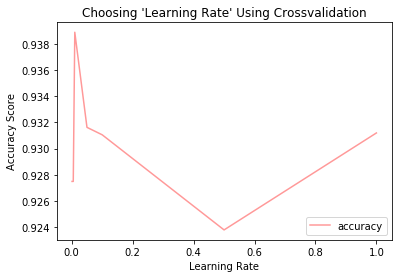

In [58]:
# AdaBoost to enhance the model even further
# Base classifier is Random Forests

# instantiate Random Forests classifier
rf = RandomForestClassifier(n_estimators = 100,
                            max_depth = 4,
			                random_state = 12345)

# learning rate needs to be derived using iterations
lrate_arr = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
acc_scores = []

for lrate in lrate_arr:
    
    # instantiate AdaBoostClassifier
    adaboost = AdaBoostClassifier(base_estimator = rf, 
				  learning_rate = lrate,
				  random_state = 12345)
    temp = []

    # perform crossvalidation
    kf = KFold(n_splits = 10, shuffle = True)
    
    for train_idx, valid_idx in kf.split(X_train):
        
        train_set_X, valid_set_X = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        train_set_y, valid_set_y = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        adaboost.fit(train_set_X.values, train_set_y['bot'].values)
        y_pred = adaboost.predict(valid_set_X.values)
            
        # get accuracy scores
        acc = accuracy_score(y_pred, valid_set_y['bot'].values)
        temp.append(acc)
        
    acc_scores.append(np.mean(temp))

# plot 'accuracy scores' as a function of 'learning rate'
plt.plot(lrate_arr, acc_scores, 'r-', alpha = 0.4, label = 'accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Score')
plt.title('Choosing \'Learning Rate\' Using Crossvalidation')
plt.legend(loc = 'lower right')
plt.show()        

Using the 10-fold Crossvalidation and using $Accuracy$ score as the metric of measure, it can be seen that model performs  better at $learning$ $rate$ of $0.01$. Therefore, at tree $depth$ of 4 and $learning$ $rate$ of 0.01 and 100 trees to be sampled, AdaBoost classifier is used to predict on test set

In [59]:
        
# learning rate is therefore best set at 0.01
# Instantiate AdaBoostClassifier at 'learning_rate' of '0.01' with RandomForest as base classifier
# Train and test the classifier
adaboost = AdaBoostClassifier(base_estimator = rf,
			      n_estimators = 100, 
			      learning_rate = 0.01,
			      random_state = 12345)
adaboost.fit(X_train.values, y_train['bot'].values)
y_pred = adaboost.predict(X_test.values)
acc = accuracy_score(y_pred, y_test['bot'].values)
print('AdaBoostClassifier Accuracy:', acc)

AdaBoostClassifier Accuracy: 0.9242424242424242


#### Analysis
Random Forest's test set accuracy score is 92.42%

## Classification Analysis

In conclusion it can be seen that the accuracy scores in classifying bots vs. humans is 92%. It is achieved using both $Random Forests$ and $AdaBoost$. It can be speculated that $AdaBoost$ might perform better when $learning rate$ and number of trees Random Forest relies on are better sampled.

# Topic Modeling

In this section, we will be looking at modeling topics i.e. identify the topics that were made as part of bot and human tweets. Also, we will be using tweet specific attributes from Section II. Natural language processing and text analysis are done to achieve _Topic Modeling_.

#### Preparing the data

In [63]:
# check the class distribution
bot_tweets = df_tweet[df_tweet['bot'] == 1].reset_index(drop = True)
bot_tweets['bot'] = 'yes'
human_tweets = df_tweet[df_tweet['bot'] == 0].reset_index(drop = True)
human_tweets['bot'] = 'no'

print('No. of human made tweets', human_tweets.shape[0])
print('No. of bot made tweets', bot_tweets.shape[0])

No. of human made tweets 34710
No. of bot made tweets 8013


Sampling the data to remove the  **Class-Imbalance Problem**

In [70]:
# preventing class imbalance problem by subsampling equal number of human tweets as bots'
human_tweets = human_tweets.iloc[np.arange(bot_tweets.shape[0])]

# merging tweets together 
tweets_modif = pd.concat([bot_tweets, human_tweets])
tweets_modif = tweets_modif.sample(frac = 1, random_state = 12345).reset_index(drop = True)

#### Text Processing

As part of text-processing, we have
1. Removed punctuation
2. Removed numbers
3. Removed stopwords
4. Converted all characters to lower-case
5. Performed $Lemmatization$

Note that _**Natural Language Tool Kit**_ has been used to perform $Lemmatization$. 

In [71]:
# text processing
tweets = tweets_modif['text'].tolist()
tweets_class = tweets_modif['bot']
punct = list(set(string.punctuation))
punct.remove('@')
punct.remove('#')
punct.append('\'')
punct.append('"')
numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
hashtags = []
tweets_copy = []
stop_w = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for i in range(len(tweets)):
    
    # change everything to lower case
    tweets[i] = str(tweets[i]).lower()  
    
    # remove URLs
    # https://stackoverflow.com/a/11332580/7551231
    tweets[i] = re.sub(r"https\S+", "", tweets[i])
    
    # removing stopwords (before punctuation removal)
    tweets[i] = " ".join(w for w in tweets[i].split() if w.strip() not in stop_w)
    
    # removing punctuation 
    tweets[i] = re.sub('["\']', '', tweets[i])    
    tweets[i] = "".join(ch for ch in tweets[i] if ch not in punct)

    # removing words that start with '@' as they are usernames
    # also, remving 'rt' word    
    tweets[i] = " ".join(w for w in tweets[i].split() if not re.match(r'^@', w) and not re.match(r'rt', w))
    hashtags.extend(list(re.sub('#', '', w) for w in tweets[i].split() if re.match(r'^#', w)))    
    tweets[i] = re.sub(r'#', '', tweets[i])
                                
    # removing numbers
    tweets[i] = "".join(ch for ch in tweets[i] if ch not in numbers)            
    
    # removing stopwords (after punctuation removal)
    tweets[i] = " ".join(w for w in tweets[i].split() if w.strip() not in stop_w)
          
    # Lemmatization is preferred over stemming although it is slow    
    pos_tag_tweets = pos_tag(word_tokenize(tweets[i]))       
    lemma_tweets = []    
    for word, tag in pos_tag_tweets:        
        tag_lower = tag[0].lower()
        tag_lower = tag_lower if tag_lower in ['a', 'r', 'n', 'l'] else None        
        lemma_tweets.append(lemmatizer.lemmatize(word, tag_lower) if tag_lower else word)
        
    # finally creating an array of words for every document
    tweets[i] = ' '.join(lemma_tweets)

#### Term Frequency - Inverse Document Frequency (TF-IDF)

In [77]:
# performing topic modelling using Latent Dirichlet Allocation
# get TF-IDF for the text documents
tfidf = TfidfVectorizer(norm = 'l2')
tfidf_matrix = tfidf.fit_transform(tweets)
feature_names = tfidf.get_feature_names()

#### Topic modeling using _Latent Dirichlet Allocation (LDA)_

Here, we will be highlighting the top 20 topics that describe the tweets

In [78]:
# Perform LDA
lda = LatentDirichletAllocation(n_components = 20,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

feature_names = tfidf.get_feature_names()
topics_retrieved = lda.fit_transform(tfidf_matrix)
n_top_words = 10

for topic_idx, topic in enumerate(lda.components_):
    print('==============================================')    
    print('topic: ', topic_idx)
    print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))

topic:  0
funny pie catfish truth cheer maryland spring regarding firefighter defend
topic:  1
de fearfactor el round sweet en la tesla favorite thing
topic:  2
html nbadunkweek season dunk top bestofnba cs powerful wtd agree
topic:  3
judge policy influencer super ep kavanaugh kbsworld image battle bootstrap
topic:  4
eaten probably driving summit cry paper care seriously nfl slide
topic:  5
ban wolf legend directed workflow earned wins acting sharkweek golang
topic:  6
lt seems isn fishing gt lol benchmark mustread keeping agriculture
topic:  7
hero inspiring pa location stuff mindset music privilege importance animal
topic:  8
accidentalhaiku fallontonight patient character founder thi stopping pinterest blue gift
topic:  9
marvel studio infinitywar العربيةعاجل ticket في habit okay theater mypov
topic:  10
gamedev indiedev instant available netflix indiegame tvma movie gamer pixelart
topic:  11
fiverr check riponthewebguy wordpress install php issue create web programming
topic:  12

#### Analysis


To understand what these topics mean, let us look at $topic$ $9$. <br> Topic - 9 highlights the keywords $theater$, $studio$, $marvel$, $infinitywar$. It can be seen that these all keywords are in a way representative of an abstract topic. We can perceive the abtsract topic here as $MOVIE$. Again, it is left to user's understanding and line of though to establish a relationship with any paradigm. <br>
Also, _topic 19_ can be easily perceived as an abstraction of $Marketing$.

# CONCLUSION

In conclusion, we have seen that
1. $Bots$ and $Humans$ can be mathematically and computationally identified and seperated using Machine Learning techniques and data analysis.
2. We have also seen how topic modelling is done using natural language processing techniques and how keywords from documents (tweets) can be grouped together to abstract a topic.